# Pluralism in Europe - Part 3: Race and Ethnicity


## Abstract
After having explored how pluralism relates to [other human values](1_Pluralism_Human_Values.ipynb), [gender and sexual diversity](2_Pluralism_Sex&Gender.ipynb), this third part of my exploration investigates its relation to race and ethnicity.

To this end, I’ve still used results from the European Social Survey (2018 edition). I’ve compared results from the UK, France and Germany and have raised some important questions about discrimination and its impact on people’s values.

As a reminder, I’m taking a broad definition of pluralism: pluralists are people believing that diversity is a good thing for society. Pluralists are people who value not just specific differences but all of them. 

It is thus not enough to sympathize with a specific community or minority group to be considered a pluralist. Pluralists value difference whatever form it takes.

- [Open call for data scientists](https://github.com/bruchansky/pluralism) 
- More about this project: https://plural.world/alternatives/measuring-pluralism/
- ESS Round 9: European Social Survey Round 9 Data (2018). Data file edition 3.1. NSD - Norwegian Centre for Research Data, Norway – Data Archive and distributor of ESS data for ESS ERIC. http://dx.doi.org/10.21338/NSD-ESS9-2018
- The Human Value Scale: https://www.europeansocialsurvey.org/docs/findings/ESS_Findings_HVS.pdf

**License**

The content of this project is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC BY-NC-SA 4.0), and the underlying source code is licensed under GPL-3.0 License.


## Initialisation & data cleansing

In [1]:
# Data source: European Social Survey Cumulative File, ESS 1-9 (2020).
# Data file edition 1.1.
# NSD - Norwegian Centre for Research Data, Norway - Data Archive and distributor of ESS data for ESS ERIC.
# www.europeansocialsurvey.org

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
# import raw dataset
ess_rawdataset = pd.read_csv("data/ESS1-9e01_1.csv", low_memory=False)

In [4]:
# extract relevant features 
# descriptions are simplified, please refer to ESS documentation for full descriptions
ess_dataset = ess_rawdataset[['cntry', # country
                              'anweight', # analysis weight that makes all survey corrections 
                              'rlgdgr', # religious from 1 (not at all) to 10 (very)                      

                              # diversity
                              'freehms', # gay and lesbians free to live as they wish (1) agree (5) disagree
                              'imdfetn', # allow many diff. race/ethnic immigrants (1) to none (4) in country
                              'blgetmg', # belong to minority ethnic group (1) yes (2) no                              
                              'dscrgrp', # feeling discriminated (1) yes (2) no
                              'dscrrce','dscrntn','dscrrlg','dscrlng','dscretn',
                              'dscrage','dscrgnd','dscrsex','dscrdsb','dscroth',
                              # discriminated by race, nationality, religion, language, ethnic group
                              # discriminatd by age, gender, sexuality, disability, other
                              # (0) not marked (1) marked
                              

                              # human values from 1 (very much like me) to 6 (not like me at all)                              
                              'ipcrtiv','imprich','ipeqopt','ipshabt',
                              'impsafe','impdiff','ipfrule','ipudrst',
                              'ipmodst','ipgdtim','impfree','iphlppl',
                              'ipsuces','ipstrgv','ipadvnt','ipbhprp',
                              'iprspot','iplylfr','impenv','imptrad',
                              'impfun'
                              # important to be creative, rich, treat equally, be admired, 
                              # to live safe, try different things, follow rules, understand different people
                              # to be modest, have good time, be free, help people
                              # to be successful, that government is strong, to seek adventures, behave properly
                              # to get respect, to be loyal to friends, to care for environment, to follow traditions
                              # to seek fun
                              ]]



In [5]:
print('Total number of respondents: '+str(ess_dataset.shape[0]))

Total number of respondents: 46276


In [6]:
# for the sake of this exploration, remove respondents who didn't provide an answer to any relevant question
ess_dataset = ess_dataset.dropna()                                
ess_dataset.drop(ess_dataset[(ess_dataset.freehms > 5) |
                             (ess_dataset.imdfetn > 4) |
                             (ess_dataset.rlgdgr > 10) |
                             (ess_dataset.blgetmg > 2) |
                             (ess_dataset.dscrgrp > 2) ].index, inplace=True)
ess_dataset.drop(ess_dataset[(ess_dataset.ipcrtiv > 6)| 
                              (ess_dataset.imprich > 6)| 
                              (ess_dataset.ipeqopt > 6)| 
                              (ess_dataset.ipshabt > 6)| 
                              (ess_dataset.impsafe > 6)| 
                              (ess_dataset.impdiff > 6)| 
                              (ess_dataset.ipfrule > 6)| 
                              (ess_dataset.ipudrst > 6)| 
                              (ess_dataset.ipmodst > 6)| 
                              (ess_dataset.ipgdtim > 6)| 
                              (ess_dataset.impfree > 6)| 
                              (ess_dataset.iphlppl > 6)| 
                              (ess_dataset.ipsuces > 6)| 
                              (ess_dataset.ipstrgv > 6)| 
                              (ess_dataset.ipadvnt > 6)| 
                              (ess_dataset.ipbhprp > 6)| 
                              (ess_dataset.iprspot > 6)| 
                              (ess_dataset.iplylfr > 6)| 
                              (ess_dataset.impenv > 6)| 
                              (ess_dataset.imptrad > 6)| 
                              (ess_dataset.impfun > 6)].index, inplace=True)
print('Total number of respondents after cleansing: '+str(ess_dataset.shape[0]))

Total number of respondents after cleansing: 40283


We have lost 13% of data entries during cleansing, which is acceptable.

## Exploring Pluralism in relation to race and ethnicity

In [7]:
# Building 4 dataframes for EU, UK, FR and DE
ess_dataset_EU = ess_dataset.copy()
ess_dataset_DE = ess_dataset[ess_dataset["cntry"] == 'DE'].copy()
ess_dataset_GB = ess_dataset[ess_dataset["cntry"] == 'GB'].copy()
ess_dataset_FR = ess_dataset[ess_dataset["cntry"] == 'FR'].copy()

### Comparing pluralism by country
As detailed in the first part of this analysis, I'm using the following general statement (‘ipudrst’ variable) to measure how much a respondent embraces difference (is a pluralist): “It is important to her/him to listen to people who are different from her/him. Even when she/he disagrees with them, she/he still wants to understand them” .

Respondents are asked to rate the general statement from 1 (very much like me) to 6 (not like me at all).

I have applied ESS analysis weights in order to make accurate comparisons between Germany, the UK and France:
https://www.europeansocialsurvey.org/docs/methodology/ESS_weighting_data_1_1.pdf

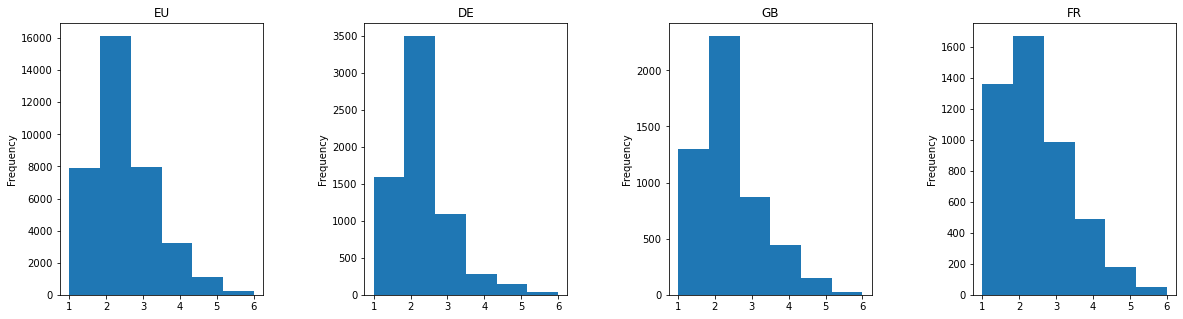

In [8]:
plt.figure(figsize = (20,5))
plt.subplot(1, 4, 1)  # 1 line, 4 rows, index nr 1 (first position in the subplot)
ess_dataset_EU['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU["anweight"], title = 'EU')
plt.subplot(1, 4, 2)  # 1 line, 4 rows, index nr 2 (second position in the subplot)
ess_dataset_DE['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE["anweight"], title = 'DE')
plt.subplot(1, 4, 3)  # 1 line, 4 rows, index nr 3 (third position in the subplot)
ess_dataset_GB['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB["anweight"], title = 'GB')
plt.subplot(1, 4, 4)  # 1 line, 4 rows, index nr 4 (fourth position in the subplot)
ess_dataset_FR['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR["anweight"], title = 'FR')
plt.subplots_adjust(wspace=0.5)
plt.show()

Again, we can see that most people in Europe, Germany, the UK and France tend to self-identify with the general statement. France is a bit different, respondents' answers are more distributed even though the trend remains the same.


### Looking at race and ethnicity
In the table below, I’ve compared people’s attitude towards the same general statement (“It is important to her/him to listen to people who are different from her/him. Even when she/he disagrees with them, she/he still wants to understand them”).

I’ve compared answers based on:
- Ethnicity: whether respondents felt they belong to a minority ethnic group or not
- A sense of being discriminated against based on race, nationality, religion, ethnicity and language
- Attitude towards immigration (for simplicity, I have selected respondents having the most positive attitude towards immigration, see appendix)
- Religiosity (for simplicity, I have selected most religious people, see appendix)

In grey are populations that are too small to make accurate comparisons.

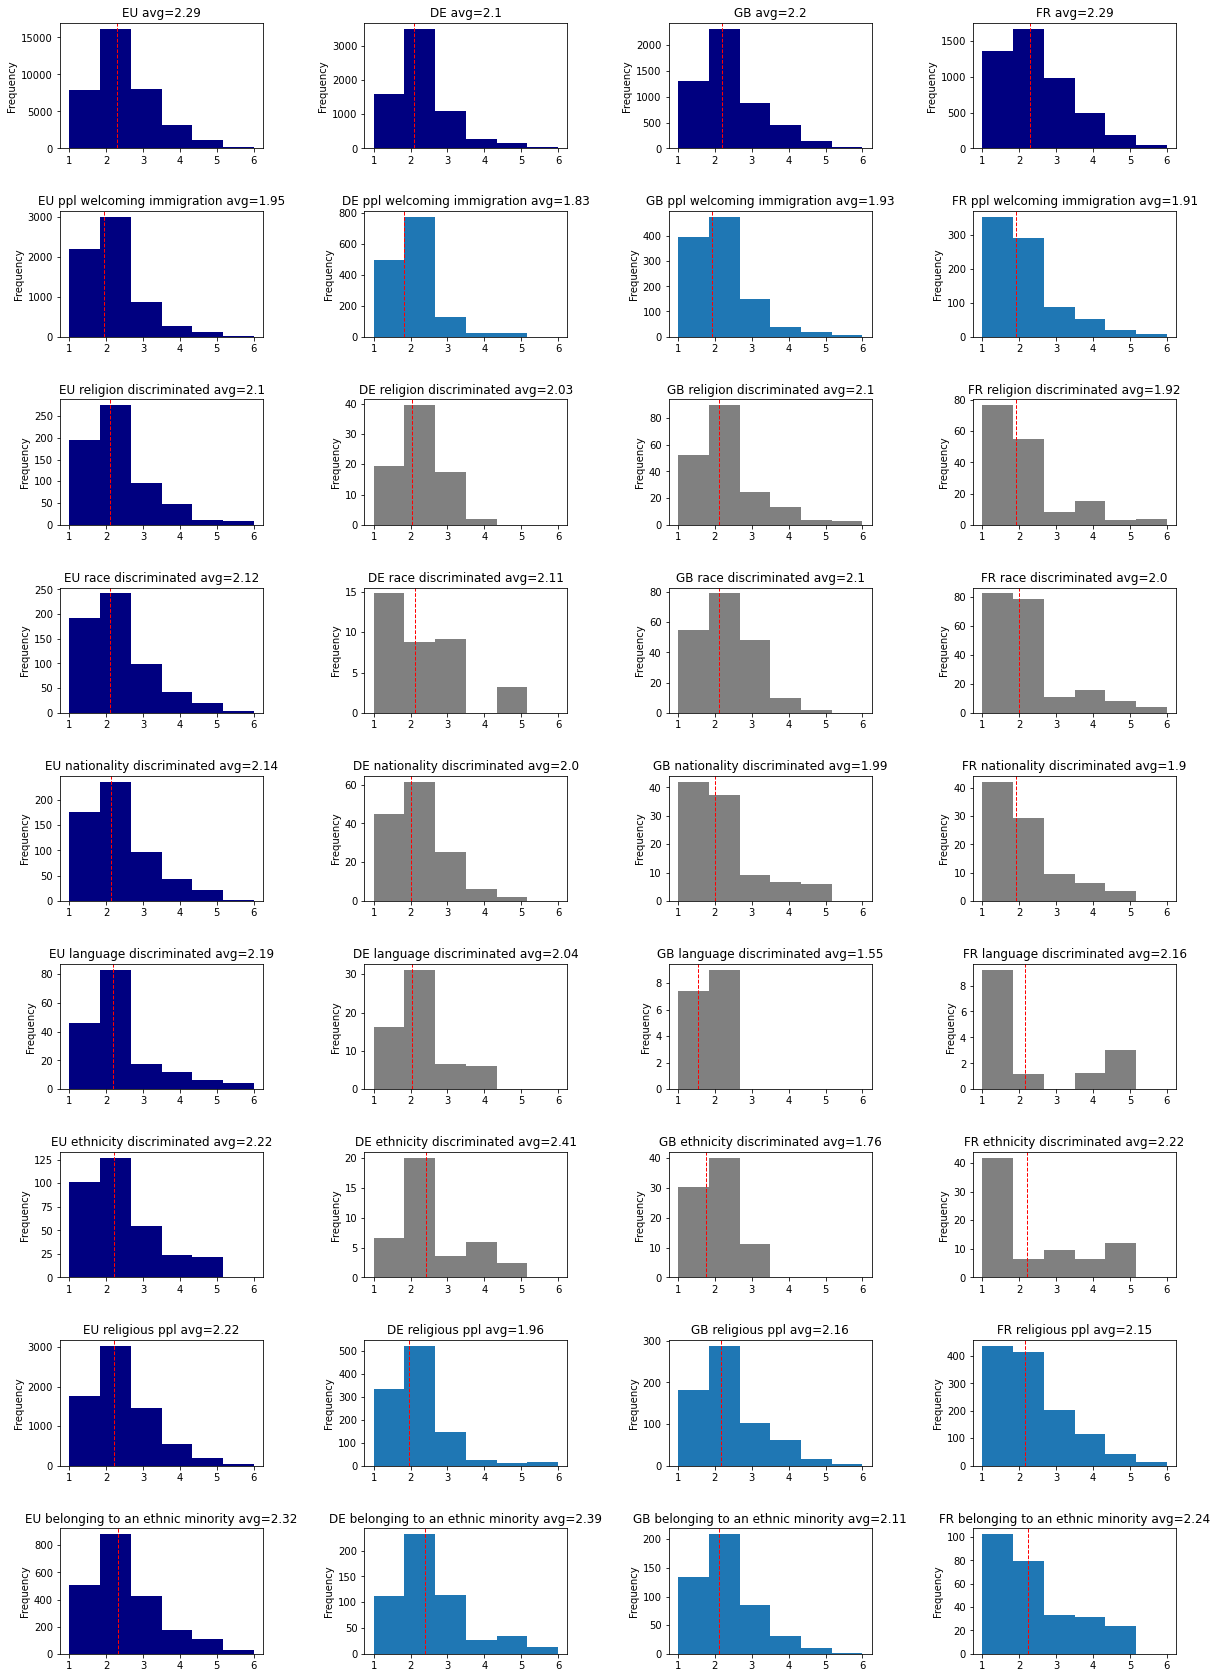

In [9]:
# function to calculate weighted average
def w_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

plt.figure(figsize = (20,30))
plt.subplot(9, 4, 1)  
ess_dataset_EU['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU["anweight"], title = 'EU avg='+round(w_avg(ess_dataset_EU, 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU, 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 2) 
ess_dataset_DE['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE["anweight"], title = 'DE avg='+round(w_avg(ess_dataset_DE, 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_DE, 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 3) 
ess_dataset_GB['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB["anweight"], title = 'GB avg='+round(w_avg(ess_dataset_GB, 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_GB, 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 4) 
ess_dataset_FR['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR["anweight"], title = 'FR avg='+round(w_avg(ess_dataset_FR, 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_FR, 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 5)  
ess_dataset_EU[ess_dataset_EU['imdfetn']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['imdfetn']==1]["anweight"], title = 'EU ppl welcoming immigration avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['imdfetn']==1], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['imdfetn']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 6)  
ess_dataset_DE[ess_dataset_DE['imdfetn']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['imdfetn']==1]["anweight"], title = 'DE ppl welcoming immigration avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['imdfetn']==1], 'ipudrst', 'anweight'),2).astype(str),range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['imdfetn']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 7)  
ess_dataset_GB[ess_dataset_GB['imdfetn']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['imdfetn']==1]["anweight"], title = 'GB ppl welcoming immigration avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['imdfetn']==1], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['imdfetn']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 8)  
ess_dataset_FR[ess_dataset_FR['imdfetn']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['imdfetn']==1]["anweight"], title = 'FR ppl welcoming immigration avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['imdfetn']==1], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['imdfetn']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 9)  
ess_dataset_EU[ess_dataset_EU['dscrrlg']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['dscrrlg']==1]["anweight"], title = 'EU religion discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscrrlg']==1], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscrrlg']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 10)  
ess_dataset_DE[ess_dataset_DE['dscrrlg']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['dscrrlg']==1]["anweight"], title = 'DE religion discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscrrlg']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscrrlg']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 11)  
ess_dataset_GB[ess_dataset_GB['dscrrlg']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['dscrrlg']==1]["anweight"], title = 'GB religion discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscrrlg']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscrrlg']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 12)  
ess_dataset_FR[ess_dataset_FR['dscrrlg']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['dscrrlg']==1]["anweight"], title = 'FR religion discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscrrlg']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscrrlg']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 13)  
ess_dataset_EU[ess_dataset_EU['dscrrce']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['dscrrce']==1]["anweight"], title = 'EU race discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscrrce']==1], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscrrce']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 14)  
ess_dataset_DE[ess_dataset_DE['dscrrce']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['dscrrce']==1]["anweight"], title = 'DE race discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscrrce']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscrrce']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 15)  
ess_dataset_GB[ess_dataset_GB['dscrrce']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['dscrrce']==1]["anweight"], title = 'GB race discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscrrce']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscrrce']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 16)  
ess_dataset_FR[ess_dataset_FR['dscrrce']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['dscrrce']==1]["anweight"], title = 'FR race discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscrrce']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscrrce']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 17)  
ess_dataset_EU[ess_dataset_EU['dscrntn']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['dscrntn']==1]["anweight"], title = 'EU nationality discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscrntn']==1], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscrntn']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 18)  
ess_dataset_DE[ess_dataset_DE['dscrntn']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['dscrntn']==1]["anweight"], title = 'DE nationality discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscrntn']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscrntn']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 19)  
ess_dataset_GB[ess_dataset_GB['dscrntn']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['dscrntn']==1]["anweight"], title = 'GB nationality discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscrntn']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscrntn']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 20)  
ess_dataset_FR[ess_dataset_FR['dscrntn']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['dscrntn']==1]["anweight"], title = 'FR nationality discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscrntn']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscrntn']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 21)  
ess_dataset_EU[ess_dataset_EU['dscrlng']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['dscrlng']==1]["anweight"], title = 'EU language discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscrlng']==1], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscrlng']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 22)  
ess_dataset_DE[ess_dataset_DE['dscrlng']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['dscrlng']==1]["anweight"], title = 'DE language discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscrlng']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscrlng']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 23)  
ess_dataset_GB[ess_dataset_GB['dscrlng']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['dscrlng']==1]["anweight"], title = 'GB language discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscrlng']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscrlng']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 24)  
ess_dataset_FR[ess_dataset_FR['dscrlng']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['dscrlng']==1]["anweight"], title = 'FR language discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscrlng']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscrlng']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 25)  
ess_dataset_EU[ess_dataset_EU['dscretn']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['dscretn']==1]["anweight"], title = 'EU ethnicity discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscretn']==1], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscretn']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 26)  
ess_dataset_DE[ess_dataset_DE['dscretn']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['dscretn']==1]["anweight"], title = 'DE ethnicity discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscretn']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscretn']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 27)  
ess_dataset_GB[ess_dataset_GB['dscretn']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['dscretn']==1]["anweight"], title = 'GB ethnicity discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscretn']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscretn']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 28)  
ess_dataset_FR[ess_dataset_FR['dscretn']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['dscretn']==1]["anweight"], title = 'FR ethnicity discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscretn']==1], 'ipudrst', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscretn']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 29)  
ess_dataset_EU[ess_dataset_EU['rlgdgr']>7]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['rlgdgr']>7]["anweight"], title = 'EU religious ppl avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['rlgdgr']>7], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['rlgdgr']>7], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 30)  
ess_dataset_DE[ess_dataset_DE['rlgdgr']>7]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['rlgdgr']>7]["anweight"], title = 'DE religious ppl avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['rlgdgr']>7], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['rlgdgr']>7], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 31)  
ess_dataset_GB[ess_dataset_GB['rlgdgr']>7]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['rlgdgr']>7]["anweight"], title = 'GB religious ppl avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['rlgdgr']>7], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['rlgdgr']>7], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 32)  
ess_dataset_FR[ess_dataset_FR['rlgdgr']>7]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['rlgdgr']>7]["anweight"], title = 'FR religious ppl avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['rlgdgr']>7], 'ipudrst', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['rlgdgr']>7], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)


plt.subplot(9, 4, 33)  
ess_dataset_EU[ess_dataset_EU['blgetmg']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_EU[ess_dataset_EU['blgetmg']==1]["anweight"], title = 'EU belonging to an ethnic minority avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['blgetmg']==1], 'ipudrst', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['blgetmg']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 34)  
ess_dataset_DE[ess_dataset_DE['blgetmg']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_DE[ess_dataset_DE['blgetmg']==1]["anweight"], title = 'DE belonging to an ethnic minority avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['blgetmg']==1], 'ipudrst', 'anweight'),2).astype(str),range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['blgetmg']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 35)  
ess_dataset_GB[ess_dataset_GB['blgetmg']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_GB[ess_dataset_GB['blgetmg']==1]["anweight"], title = 'GB belonging to an ethnic minority avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['blgetmg']==1], 'ipudrst', 'anweight'),2).astype(str),range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['blgetmg']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 36)  
ess_dataset_FR[ess_dataset_FR['blgetmg']==1]['ipudrst'].plot.hist(bins=6,weights=ess_dataset_FR[ess_dataset_FR['blgetmg']==1]["anweight"], title = 'FR belonging to an ethnic minority avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['blgetmg']==1], 'ipudrst', 'anweight'),2).astype(str),range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['blgetmg']==1], 'ipudrst', 'anweight'), color='r', linestyle='dashed', linewidth=1)


plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.show()

First observation is that while histograms have similar shapes than in part 2, averages vary less than for gender and sexual diversity (EU averages vary by 0.37 vs 0.55 in part 2). 

A significant difference with gender and sexual diversity is that people being discriminated against based on race, nationality, religion, ethnicity and language are less likely to embrace diversity than those welcoming immigration.

Most are still more likely to embrace diversity than on average though, with the exception of ethnic minorities based in Germany (other groups are too small to draw any conclusion).

Perhaps surprisingly, very religious people are also more likely to embrace diversity. 

These results are probably too generic. Knowing what immigration, races, nationalities, religions, ethnicities and languages we are talking about would provide a better insight. But this is out of this exploration’s scope (contributions are more than welcomed!).

What these diagrams tell us is that, overall, religion, race and ethnic differences don't lead to the sort of intolerance and sectarianism entertained by some media. But they are not a game changer in terms of attitude towards diversity either. 


### Cross Checking with attitude towards gay men and lesbians

Results above seem to indicate that people strongly in favour immigration are also more appreciative of diversity.

To verify this, I’m going to compare their response to the following general statement: “Gay men and lesbians should be free to live their own life as they wish”

(1 = agree strongly, 5 = disagree strongly)


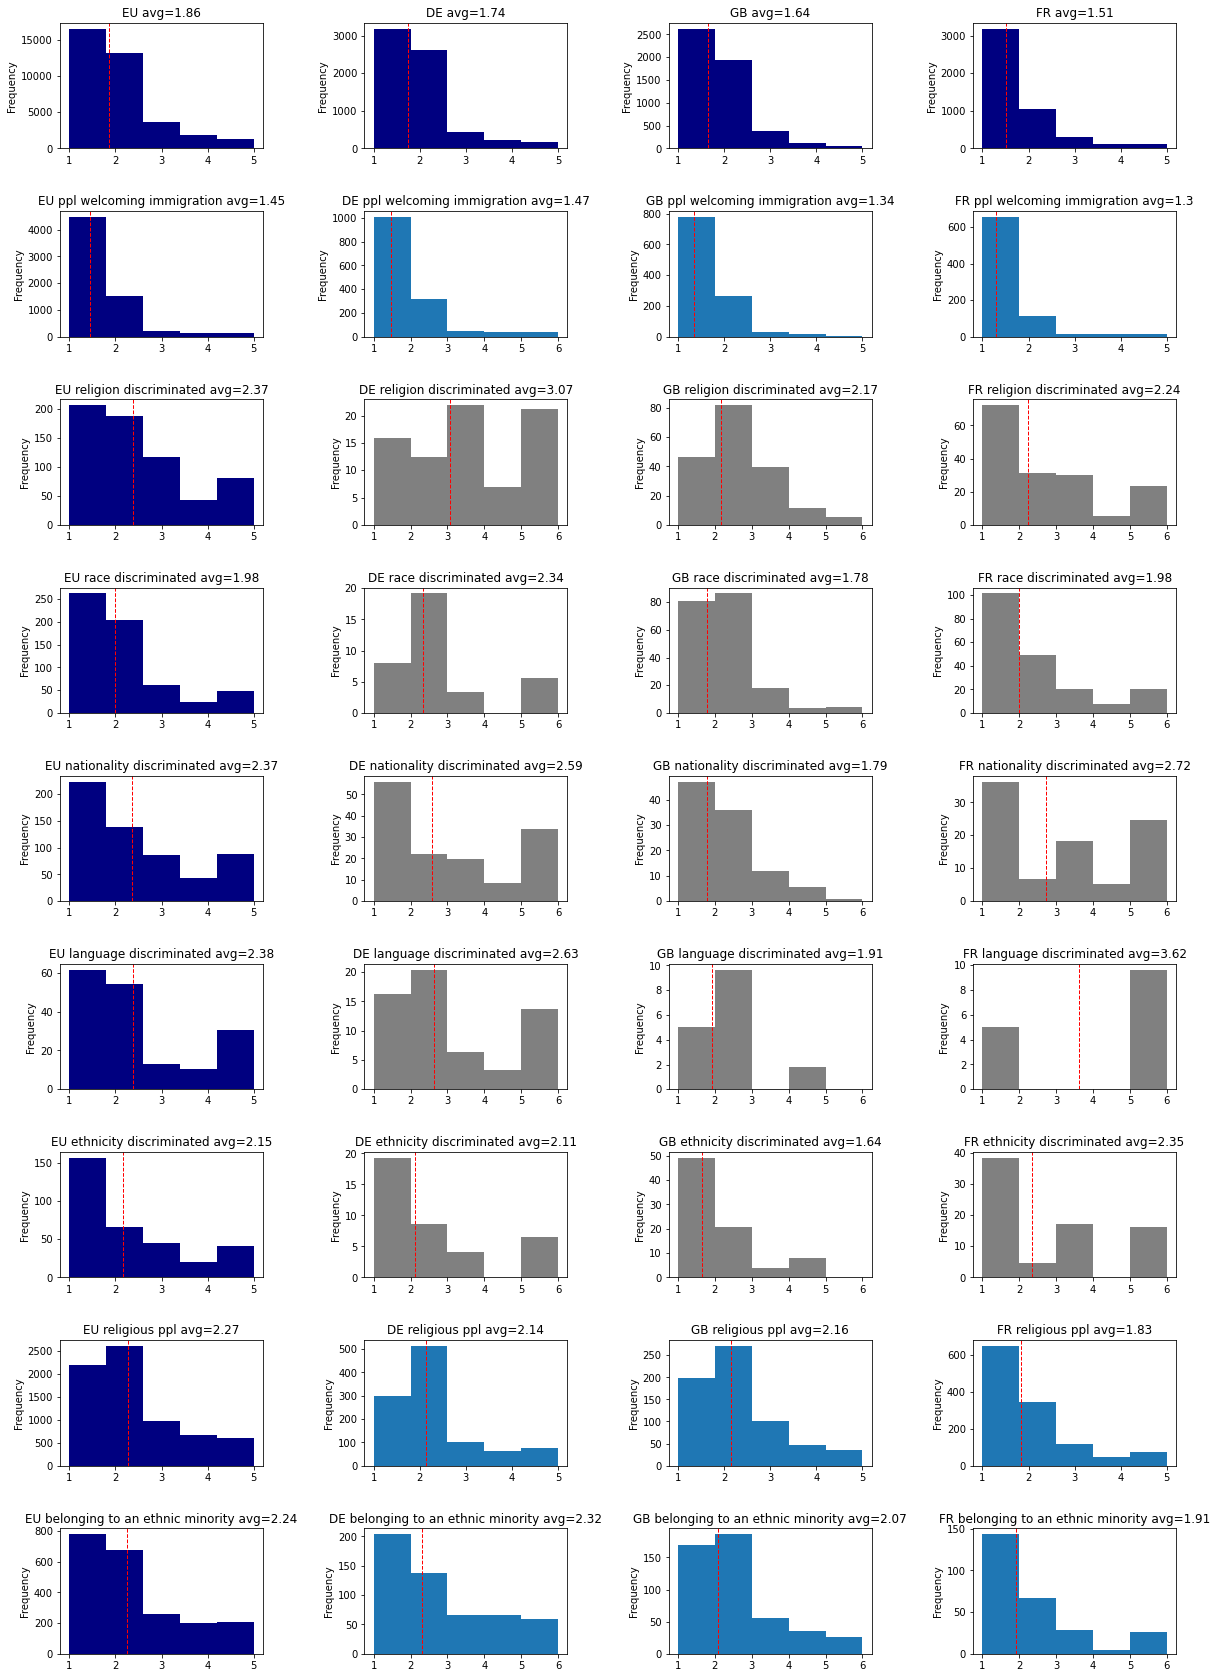

In [10]:
plt.figure(figsize = (20,30))
plt.subplot(9, 4, 1)  
ess_dataset_EU['freehms'].plot.hist(bins=5,weights=ess_dataset_EU["anweight"], title = 'EU avg='+round(w_avg(ess_dataset_EU, 'freehms', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU, 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 2) 
ess_dataset_DE['freehms'].plot.hist(bins=5,weights=ess_dataset_DE["anweight"], title = 'DE avg='+round(w_avg(ess_dataset_DE, 'freehms', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_DE, 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 3) 
ess_dataset_GB['freehms'].plot.hist(bins=5,weights=ess_dataset_GB["anweight"], title = 'GB avg='+round(w_avg(ess_dataset_GB, 'freehms', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_GB, 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 4) 
ess_dataset_FR['freehms'].plot.hist(bins=5,weights=ess_dataset_FR["anweight"], title = 'FR avg='+round(w_avg(ess_dataset_FR, 'freehms', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_FR, 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 5)  
ess_dataset_EU[ess_dataset_EU['imdfetn']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_EU[ess_dataset_EU['imdfetn']==1]["anweight"], title = 'EU ppl welcoming immigration avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['imdfetn']==1], 'freehms', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['imdfetn']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 6)  
ess_dataset_DE[ess_dataset_DE['imdfetn']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_DE[ess_dataset_DE['imdfetn']==1]["anweight"], title = 'DE ppl welcoming immigration avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['imdfetn']==1], 'freehms', 'anweight'),2).astype(str),range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['imdfetn']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 7)  
ess_dataset_GB[ess_dataset_GB['imdfetn']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_GB[ess_dataset_GB['imdfetn']==1]["anweight"], title = 'GB ppl welcoming immigration avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['imdfetn']==1], 'freehms', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['imdfetn']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 8)  
ess_dataset_FR[ess_dataset_FR['imdfetn']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_FR[ess_dataset_FR['imdfetn']==1]["anweight"], title = 'FR ppl welcoming immigration avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['imdfetn']==1], 'freehms', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['imdfetn']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 9)  
ess_dataset_EU[ess_dataset_EU['dscrrlg']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_EU[ess_dataset_EU['dscrrlg']==1]["anweight"], title = 'EU religion discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscrrlg']==1], 'freehms', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscrrlg']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 10)  
ess_dataset_DE[ess_dataset_DE['dscrrlg']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_DE[ess_dataset_DE['dscrrlg']==1]["anweight"], title = 'DE religion discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscrrlg']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscrrlg']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 11)  
ess_dataset_GB[ess_dataset_GB['dscrrlg']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_GB[ess_dataset_GB['dscrrlg']==1]["anweight"], title = 'GB religion discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscrrlg']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscrrlg']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 12)  
ess_dataset_FR[ess_dataset_FR['dscrrlg']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_FR[ess_dataset_FR['dscrrlg']==1]["anweight"], title = 'FR religion discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscrrlg']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscrrlg']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 13)  
ess_dataset_EU[ess_dataset_EU['dscrrce']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_EU[ess_dataset_EU['dscrrce']==1]["anweight"], title = 'EU race discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscrrce']==1], 'freehms', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscrrce']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 14)  
ess_dataset_DE[ess_dataset_DE['dscrrce']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_DE[ess_dataset_DE['dscrrce']==1]["anweight"], title = 'DE race discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscrrce']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscrrce']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 15)  
ess_dataset_GB[ess_dataset_GB['dscrrce']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_GB[ess_dataset_GB['dscrrce']==1]["anweight"], title = 'GB race discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscrrce']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscrrce']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 16)  
ess_dataset_FR[ess_dataset_FR['dscrrce']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_FR[ess_dataset_FR['dscrrce']==1]["anweight"], title = 'FR race discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscrrce']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscrrce']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 17)  
ess_dataset_EU[ess_dataset_EU['dscrntn']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_EU[ess_dataset_EU['dscrntn']==1]["anweight"], title = 'EU nationality discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscrntn']==1], 'freehms', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscrntn']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 18)  
ess_dataset_DE[ess_dataset_DE['dscrntn']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_DE[ess_dataset_DE['dscrntn']==1]["anweight"], title = 'DE nationality discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscrntn']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscrntn']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 19)  
ess_dataset_GB[ess_dataset_GB['dscrntn']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_GB[ess_dataset_GB['dscrntn']==1]["anweight"], title = 'GB nationality discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscrntn']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscrntn']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 20)  
ess_dataset_FR[ess_dataset_FR['dscrntn']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_FR[ess_dataset_FR['dscrntn']==1]["anweight"], title = 'FR nationality discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscrntn']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscrntn']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 21)  
ess_dataset_EU[ess_dataset_EU['dscrlng']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_EU[ess_dataset_EU['dscrlng']==1]["anweight"], title = 'EU language discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscrlng']==1], 'freehms', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscrlng']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 22)  
ess_dataset_DE[ess_dataset_DE['dscrlng']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_DE[ess_dataset_DE['dscrlng']==1]["anweight"], title = 'DE language discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscrlng']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscrlng']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 23)  
ess_dataset_GB[ess_dataset_GB['dscrlng']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_GB[ess_dataset_GB['dscrlng']==1]["anweight"], title = 'GB language discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscrlng']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscrlng']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 24)  
ess_dataset_FR[ess_dataset_FR['dscrlng']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_FR[ess_dataset_FR['dscrlng']==1]["anweight"], title = 'FR language discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscrlng']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscrlng']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 25)  
ess_dataset_EU[ess_dataset_EU['dscretn']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_EU[ess_dataset_EU['dscretn']==1]["anweight"], title = 'EU ethnicity discriminated avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['dscretn']==1], 'freehms', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['dscretn']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 26)  
ess_dataset_DE[ess_dataset_DE['dscretn']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_DE[ess_dataset_DE['dscretn']==1]["anweight"], title = 'DE ethnicity discriminated avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['dscretn']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['dscretn']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 27)  
ess_dataset_GB[ess_dataset_GB['dscretn']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_GB[ess_dataset_GB['dscretn']==1]["anweight"], title = 'GB ethnicity discriminated avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['dscretn']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['dscretn']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 28)  
ess_dataset_FR[ess_dataset_FR['dscretn']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_FR[ess_dataset_FR['dscretn']==1]["anweight"], title = 'FR ethnicity discriminated avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['dscretn']==1], 'freehms', 'anweight'),2).astype(str),color = "grey",range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['dscretn']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)

plt.subplot(9, 4, 29)  
ess_dataset_EU[ess_dataset_EU['rlgdgr']>7]['freehms'].plot.hist(bins=5,weights=ess_dataset_EU[ess_dataset_EU['rlgdgr']>7]["anweight"], title = 'EU religious ppl avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['rlgdgr']>7], 'freehms', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['rlgdgr']>7], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 30)  
ess_dataset_DE[ess_dataset_DE['rlgdgr']>7]['freehms'].plot.hist(bins=5,weights=ess_dataset_DE[ess_dataset_DE['rlgdgr']>7]["anweight"], title = 'DE religious ppl avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['rlgdgr']>7], 'freehms', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['rlgdgr']>7], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 31)  
ess_dataset_GB[ess_dataset_GB['rlgdgr']>7]['freehms'].plot.hist(bins=5,weights=ess_dataset_GB[ess_dataset_GB['rlgdgr']>7]["anweight"], title = 'GB religious ppl avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['rlgdgr']>7], 'freehms', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['rlgdgr']>7], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 32)  
ess_dataset_FR[ess_dataset_FR['rlgdgr']>7]['freehms'].plot.hist(bins=5,weights=ess_dataset_FR[ess_dataset_FR['rlgdgr']>7]["anweight"], title = 'FR religious ppl avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['rlgdgr']>7], 'freehms', 'anweight'),2).astype(str))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['rlgdgr']>7], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)


plt.subplot(9, 4, 33)  
ess_dataset_EU[ess_dataset_EU['blgetmg']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_EU[ess_dataset_EU['blgetmg']==1]["anweight"], title = 'EU belonging to an ethnic minority avg='+round(w_avg(ess_dataset_EU[ess_dataset_EU['blgetmg']==1], 'freehms', 'anweight'),2).astype(str),color = "navy")
plt.axvline(w_avg(ess_dataset_EU[ess_dataset_EU['blgetmg']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 34)  
ess_dataset_DE[ess_dataset_DE['blgetmg']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_DE[ess_dataset_DE['blgetmg']==1]["anweight"], title = 'DE belonging to an ethnic minority avg='+round(w_avg(ess_dataset_DE[ess_dataset_DE['blgetmg']==1], 'freehms', 'anweight'),2).astype(str),range=(1, 6))
plt.axvline(w_avg(ess_dataset_DE[ess_dataset_DE['blgetmg']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 35)  
ess_dataset_GB[ess_dataset_GB['blgetmg']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_GB[ess_dataset_GB['blgetmg']==1]["anweight"], title = 'GB belonging to an ethnic minority avg='+round(w_avg(ess_dataset_GB[ess_dataset_GB['blgetmg']==1], 'freehms', 'anweight'),2).astype(str),range=(1, 6))
plt.axvline(w_avg(ess_dataset_GB[ess_dataset_GB['blgetmg']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)
plt.subplot(9, 4, 36)  
ess_dataset_FR[ess_dataset_FR['blgetmg']==1]['freehms'].plot.hist(bins=5,weights=ess_dataset_FR[ess_dataset_FR['blgetmg']==1]["anweight"], title = 'FR belonging to an ethnic minority avg='+round(w_avg(ess_dataset_FR[ess_dataset_FR['blgetmg']==1], 'freehms', 'anweight'),2).astype(str),range=(1, 6))
plt.axvline(w_avg(ess_dataset_FR[ess_dataset_FR['blgetmg']==1], 'freehms', 'anweight'), color='r', linestyle='dashed', linewidth=1)


plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.show()

People in favour of immigration also sympathize more with gay men and lesbians, which does validate my hypothesis in the above section.

However, attitude towards gay men and lesbians is significantly different in other groups, often because of a minority of respondents feeling strongly against them. This is not suprising given complicated links between sex orientation, gender, ethnicities and religions. 

Ethnic minorities are on average less likely to sympathize with gay men and lesbians, especially in Germany, which confirms findings from the previous section. 

The same goes for all other categories, though a bit less in the UK where people feeling discriminated against because of race, nationality and ethnicity are only slightly less likely to sympathize with gay men and lesbians.

Sexual orientation seems also to be less of an an issue for victims or racial discrimination across Europe.

As in the previous section, knowing what immigration, races, nationalities, religions, ethnicities and languages we are talking about would provide a better insight.

But what we can see is that being discriminated against doesn't always translate to sympathy towards other minorities and sociocultural groups.

To repeat, this seems to apply only to a subgroup of people being discriminated against because of race, nationality, religion, ethnicity and language. It would be interesting to understand their thinking. Is it because they believe in diversity, they recognise it is their own interest, but consider that some sociocultural groups ask for too much or don't deserve the same level of attention? Or is it because they ultimately don’t embrace diversity, and by doing so act against their own interest? 

### Appendix 1: Attitude towards immigration

As noted in the main results, I have selected people having the most positive attitude towards immigration to study the impact it has on embracing diversity.

Here is a more detailed analysis performed at the European level and without using design weights.

Each diagram shows how respondents feel about "allowing many/few immigrants of different race/ethnic group from majority" (1 =allow many to come and live here, 5 = allow none).

In colour are proportions of respondents believing it is "important to listen to people who are different from them" (1 = very much like me, 6 = not like me at all).

On the right are the same results but normalised. 


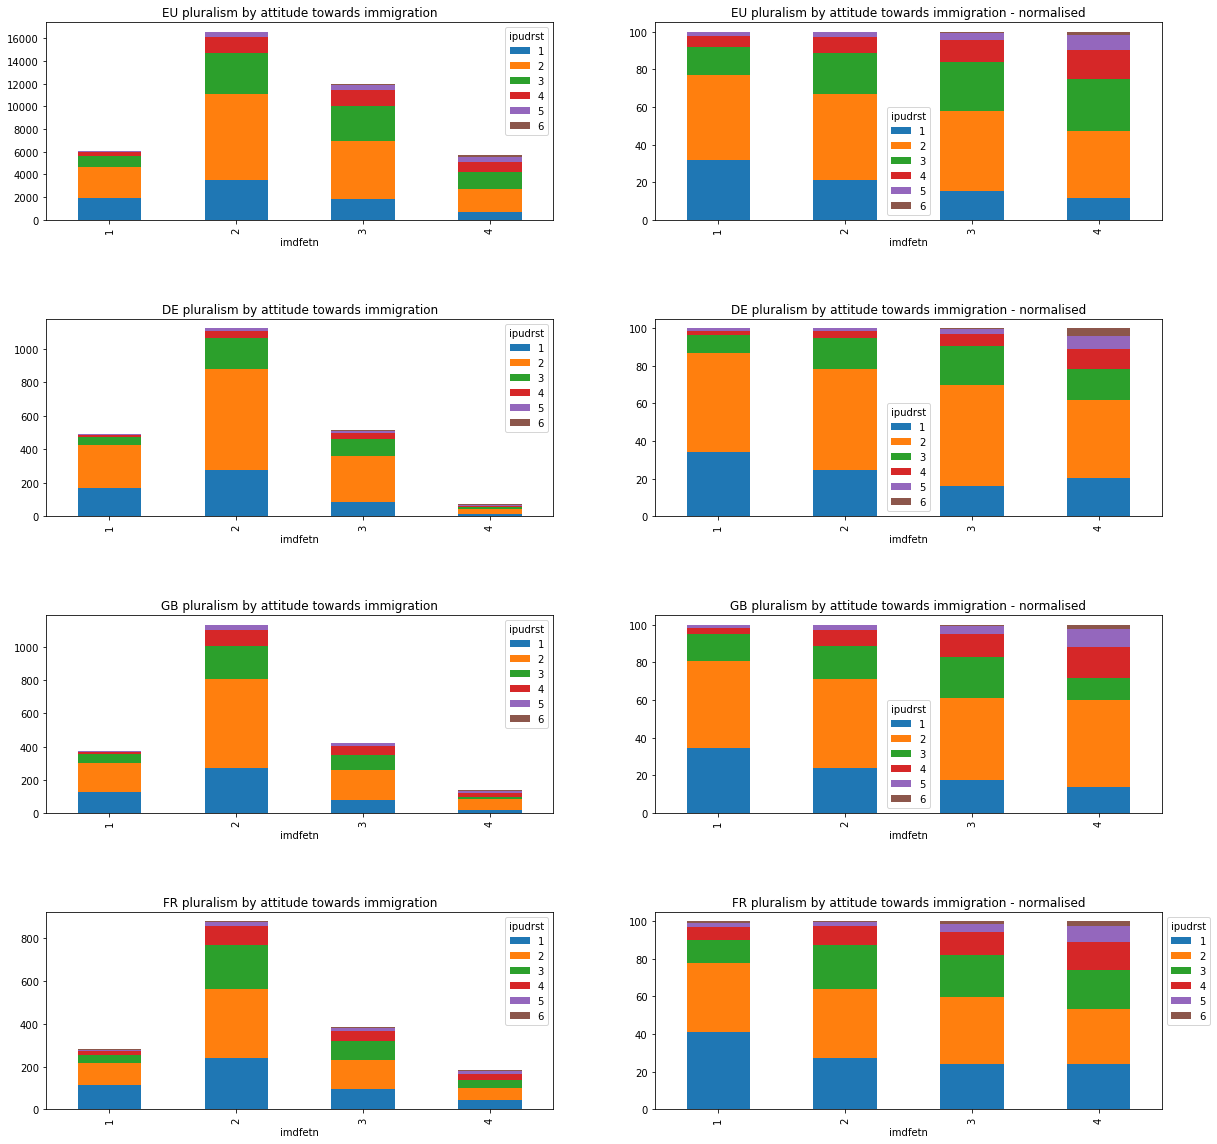

In [11]:
# I've not used weighted axes here for simplicity
fig, axes = plt.subplots(nrows=4, ncols=2)

stacked_data = ess_dataset_EU.groupby(['imdfetn', 'ipudrst']).agg('size').unstack()
stacked_data.plot(kind="bar", stacked=True,ax=axes[0,0],figsize = (20,20), title='EU pluralism by attitude towards immigration')
stacked_data = ess_dataset_EU.groupby(['imdfetn', 'ipudrst']).agg('size').unstack().apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, ax=axes[0,1], title='EU pluralism by attitude towards immigration - normalised')

stacked_data = ess_dataset_DE.groupby(['imdfetn', 'ipudrst']).agg('size').unstack()
stacked_data.plot(kind="bar", stacked=True,ax=axes[1,0], title='DE pluralism by attitude towards immigration')
stacked_data = ess_dataset_DE.groupby(['imdfetn', 'ipudrst']).agg('size').unstack().fillna(0).apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, ax=axes[1,1], title='DE pluralism by attitude towards immigration - normalised')

stacked_data = ess_dataset_GB.groupby(['imdfetn', 'ipudrst']).agg('size').unstack()
stacked_data.plot(kind="bar", stacked=True,ax=axes[2,0], title='GB pluralism by attitude towards immigration')
stacked_data = ess_dataset_GB.groupby(['imdfetn', 'ipudrst']).agg('size').unstack().fillna(0).apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, ax=axes[2,1], title='GB pluralism by attitude towards immigration - normalised')

stacked_data = ess_dataset_FR.groupby(['imdfetn', 'ipudrst']).agg('size').unstack()
stacked_data.plot(kind="bar", stacked=True,ax=axes[3,0], title='FR pluralism by attitude towards immigration')
stacked_data = ess_dataset_FR.groupby(['imdfetn', 'ipudrst']).agg('size').unstack().fillna(0).apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, ax=axes[3,1], title='FR pluralism by attitude towards immigration - normalised')

plt.subplots_adjust(hspace=0.5)
plt.legend(bbox_to_anchor=(1.0, 1.0),title='ipudrst')

Overal, we can see that the relation is linear: the more people welcome immigration, the more they are likely to welcome difference. Those answering by (1) provided the most distinct answers about pluralism, this is why I have used this category in my main analysis. 

### Appendix 2: Attitude towards religion
I’m now doing the same for religion. As noted in the main results, I have selected the most religious people to study the impact religiosity has on embracing diversity.

Each diagram shows how respondents have answered to the following question: "Regardless of whether you belong to a particular religion, how religious would you say you are?"
(1 = Not at all religious, 10 =Very religious).

In colour are proportions of respondents believing it is "important to listen to people who are different from them" (1 = very much like me, 6 = not like me at all).

On the right are the same results but normalised. 

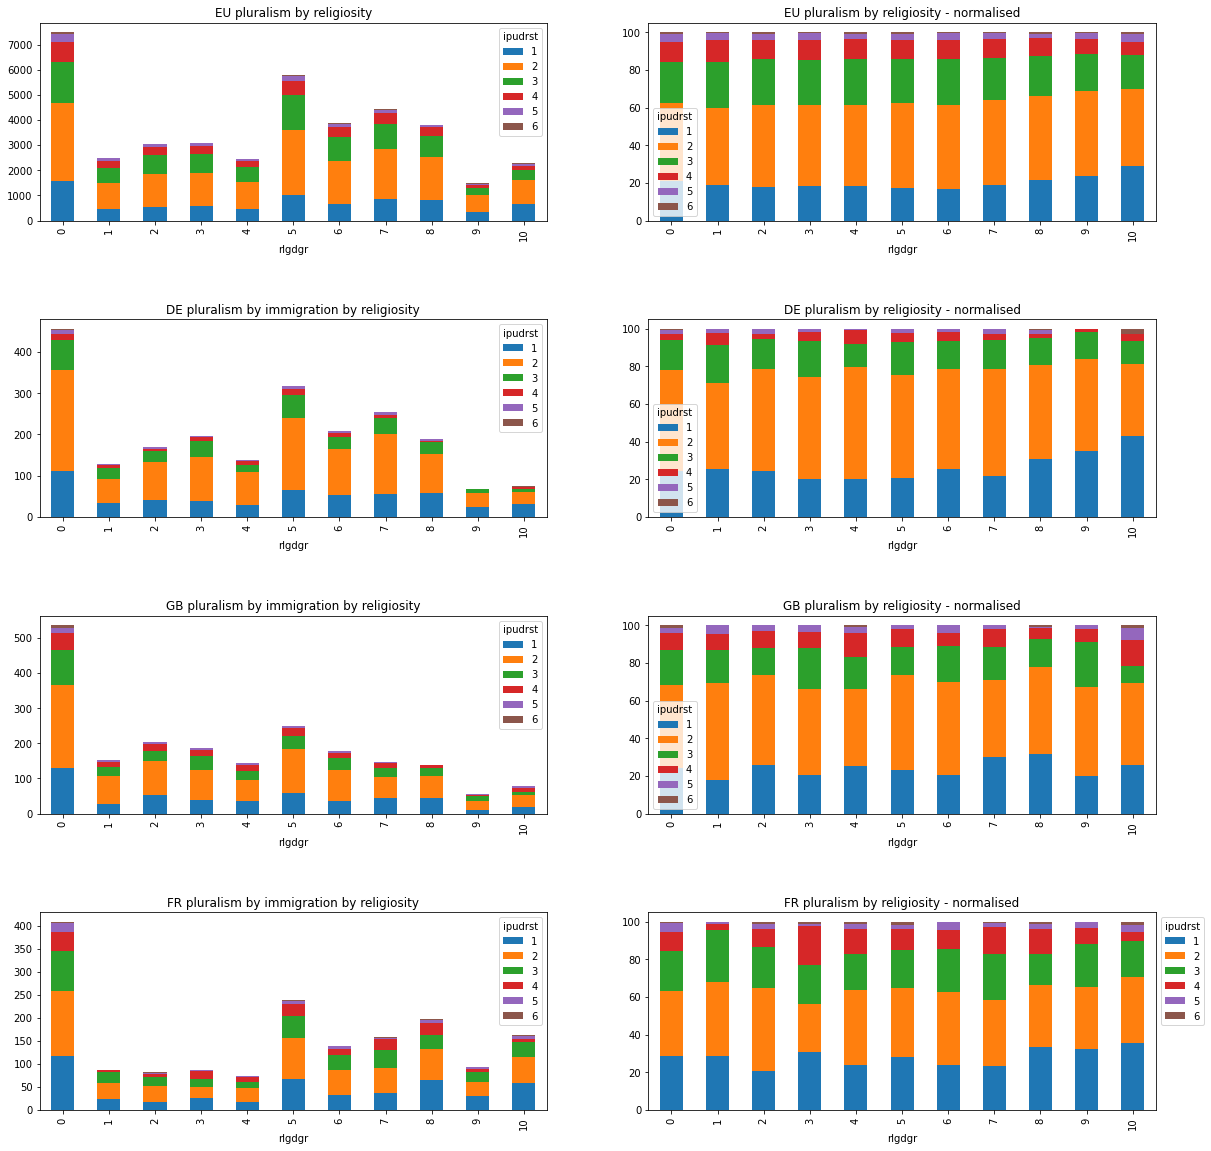

In [12]:
# I've not used weighted axes here for simplicity
fig, axes = plt.subplots(nrows=4, ncols=2)

stacked_data = ess_dataset_EU.groupby(['rlgdgr', 'ipudrst']).agg('size').unstack()
stacked_data.plot(kind="bar", stacked=True,ax=axes[0,0],figsize = (20,20), title='EU pluralism by religiosity')
stacked_data = ess_dataset_EU.groupby(['rlgdgr', 'ipudrst']).agg('size').unstack().apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, ax=axes[0,1], title='EU pluralism by religiosity - normalised')

stacked_data = ess_dataset_DE.groupby(['rlgdgr', 'ipudrst']).agg('size').unstack()
stacked_data.plot(kind="bar", stacked=True,ax=axes[1,0], title='DE pluralism by immigration by religiosity')
stacked_data = ess_dataset_DE.groupby(['rlgdgr', 'ipudrst']).agg('size').unstack().fillna(0).apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, ax=axes[1,1], title='DE pluralism by religiosity - normalised')

stacked_data = ess_dataset_GB.groupby(['rlgdgr', 'ipudrst']).agg('size').unstack()
stacked_data.plot(kind="bar", stacked=True,ax=axes[2,0], title='GB pluralism by immigration by religiosity')
stacked_data = ess_dataset_GB.groupby(['rlgdgr', 'ipudrst']).agg('size').unstack().fillna(0).apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, ax=axes[2,1], title='GB pluralism by religiosity - normalised')

stacked_data = ess_dataset_FR.groupby(['rlgdgr', 'ipudrst']).agg('size').unstack()
stacked_data.plot(kind="bar", stacked=True,ax=axes[3,0], title='FR pluralism by immigration by religiosity')
stacked_data = ess_dataset_FR.groupby(['rlgdgr', 'ipudrst']).agg('size').unstack().fillna(0).apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, ax=axes[3,1], title='FR pluralism by religiosity - normalised')

plt.subplots_adjust(hspace=0.5)
plt.legend(bbox_to_anchor=(1.0, 1.0),title='ipudrst')

Differences are not as marked as in the previous section, particulalry for the UK and France. 
Overall, those answering with 10 provided the most distinct answers about pluralism, this is why I have used this category in my main analysis. 